In [67]:
import rioxarray
import xarray as xr
import numpy as np

import os
import glob
import pathlib
import json
import boto3
import s3fs
import shutil
from typing import Any, Dict, Generic, Iterable, List, Optional, TypeVar, Union, cast
from datetime import datetime
from pprint import pprint

import geopandas as gpd
from shapely.geometry import box, mapping, Polygon, LinearRing
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Delete this block once we are in GDAL >= 3.5

awsdir = pathlib.Path("~/.aws").expanduser()
awsdir.mkdir(exist_ok=True)
awscred = awsdir / "credentials"

session = boto3.session.Session()
credentials = session.get_credentials()
credentials = credentials.get_frozen_credentials()

#Credentials are refreshable, so accessing your access key / secret key
#separately can lead to a race condition. Use this to get an actual matched
#set. 

outstring = f"""
[default]
aws_access_key_id={credentials.access_key}
aws_secret_access_key={credentials.secret_key}
aws_session_token={credentials.token}
"""
with awscred.open(mode='w') as f:
    f.write(outstring)

In [5]:
Bucket = "dh-shift-curated"

In [65]:
# additional dates after 20220412 to be added later
dates = ['20220224', 
         '20220228', 
         #'20220308', 
         '20220316', 
         '20220322', 
         '20220405', 
         '20220412'
        ]

In [63]:
# Read in data from S3 bucket
def get_zarrs(Bucket, dataset_date):
    s3 = boto3.client('s3')
    Prefix = f'aviris/{dataset_date}'
    kwargs = {'Bucket': Bucket, 'Prefix': Prefix}
    substring = '100-100-100.zarr'
    links = []
    while True:
        objects = s3.list_objects_v2(**kwargs)
        for obj in objects['Contents']:
            if substring in obj['Key']:
                key = obj['Key']
                url = key[:key.index(substring)+ len(substring)]
                zarr = url.replace(f"aviris/{dataset_date}/", "")
                links.append(str(zarr))

        try:
            kwargs['ContinuationToken'] = objects['NextContinuationToken']
        except KeyError:
            break

    data_set = set(links)
    data = list(data_set)
    pprint(data) # see results
    return data

In [64]:
def test_zarr(Bucket, dataset_date, zarr):
    Prefix = f"aviris/{dataset_date}/{zarr}"
    s3_key = os.path.join(Bucket, Prefix)

    # Open flight path zarr
    s3 = s3fs.S3FileSystem(anon=False, client_kwargs=dict(region_name='us-west-2'))
    s3_path = f"s3://{s3_key}"
    store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
    ds = xr.open_zarr(store=store, decode_coords="all", consolidated=True)

    # Set dimensions and coordinates
    ds = ds.rio.set_spatial_dims(x_dim='x', y_dim='y')
    ds = ds.set_coords(('Easting', 'Northing'))

    if np.isnan(np.max(ds.Easting.values)) or np.isnan(np.min(ds.Easting.values)) or np.isnan(np.max(ds.Northing.values)) or np.isnan(np.min(ds.Northing.values)):
        print("Error with Zarr!")
        bad_zarrs.append(zarr)
    else:
        print("Zarr ok!")
        print("Max Easting:", np.max(ds.Easting.values))
        print("Min Easting:", np.min(ds.Easting.values))
        print("Max Northing:", np.max(ds.Northing.values))
        print("Min Northing:", np.min(ds.Northing.values))

        # Calculate extent, bbox, and footprint using Easting & Northing
        ul = ds.isel(x=0, y=0)  # Upper left corner
        ur = ds.isel(x=-1, y=0) # Upper right corner
        ll = ds.isel(x=0, y=-1) # Lower left corner
        lr = ds.isel(x=-1, y=-1) # Lower right corner

        ul2 = (np.min(ul.Easting.values), np.max(ul.Northing.values))
        ur2 = (np.max(ur.Easting.values), np.max(ur.Northing.values))
        ll2 = (np.min(ll.Easting.values), np.min(ll.Northing.values))
        lr2 = (np.max(lr.Easting.values), np.min(lr.Northing.values))

        extent = Polygon([ul2, ll2, lr2, ur2])
        bbox = extent.bounds
        print(extent)
        print(bbox)

        good_zarrs.append(zarr)

        #plt.plot(*extent.exterior.xy)

['ang20220224t203333_100-100-100.zarr',
 'ang20220224t215759_100-100-100.zarr',
 'ang20220224t204803_100-100-100.zarr',
 'ang20220224t221356_100-100-100.zarr',
 'ang20220224t210144_100-100-100.zarr',
 'ang20220224t195402_100-100-100.zarr',
 'ang20220224t200332_100-100-100.zarr',
 'ang20220224t201928_100-100-100.zarr',
 'ang20220224t223027_100-100-100.zarr',
 'ang20220224t211618_100-100-100.zarr',
 'ang20220224t214423_100-100-100.zarr',
 'ang20220224t213004_100-100-100.zarr']
Zarr ok!
Max Easting: 778165.793958545
Min Easting: 721388.0436476368
Max Northing: 3862191.6675922186
Min Northing: 3816086.3252756973
POLYGON ((776769.7982585812 3862191.6675922186, 721415.6553595056 3818513.9878858975, 723114.6965541189 3816086.3252756973, 778165.793958545 3860194.097782634, 776769.7982585812 3862191.6675922186))
(721415.6553595056, 3816086.3252756973, 778165.793958545, 3862191.6675922186)
Zarr ok!
Max Easting: 785953.8939237966
Min Easting: 729214.9556440044
Max Northing: 3852283.067099589
Min 

KeyboardInterrupt: 

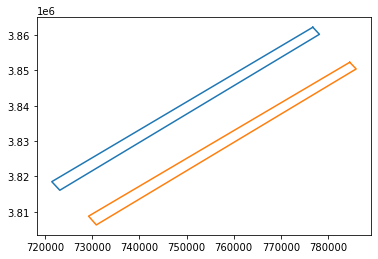

In [66]:
bad_zarrs = []
good_zarrs = []

for dataset_date in dates:
    data = get_zarrs(Bucket, dataset_date)
    for zarr in data:
        test_zarr(Bucket, dataset_date, zarr)
        
print("Bad Zarrs:", bad_zarrs)
print("Good Zarrs:", good_zarrs)